In [108]:
from sheet_id.models.FCN import FCN
from sheet_id.utils.loss_functions import softmax_sparse_crossentropy_ignoring_background, softmax_sparse_crossentropy
from sheet_id.utils.metrics import sparse_accuracy_ignoring_background, sparse_accuracy
from sheet_id.utils.dataPreprocessing import splitTrainValidation
from sheet_id.utils.dataGenerator import DataGenerator
from sheet_id.utils.dwd_utils import generateGroundTruthMaps

from keras.layers.convolutional import Conv2D
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

from sheet_id.utils.base_utils import generateSheetMaskAnnotation
from sheet_id.utils.eval_utils import evaluate
from sheet_id.utils.dwd_utils import generateGroundTruthMaps

import glob
import math
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from copy import deepcopy

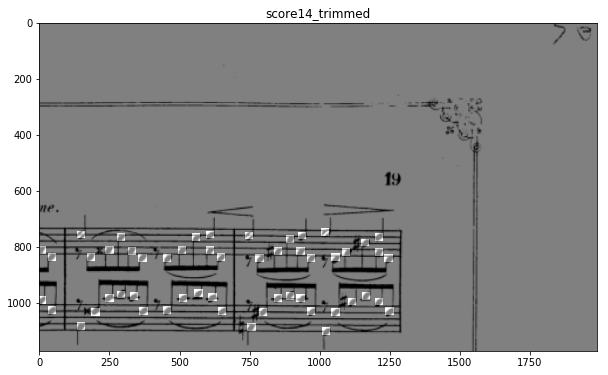

In [582]:
annotations = generateSheetMaskAnnotation(trimmed=True)
for key in ['score14_trimmed']:
    plt.figure(figsize=(10,10))
    plt.imshow(annotations[key][0][:,1500:], cmap='gray')
    plt.imshow(annotations[key][1][:,1500:], cmap='gray', alpha=0.5)
    boxes = annotations[key][2]
    plt.title(key)
    plt.show()

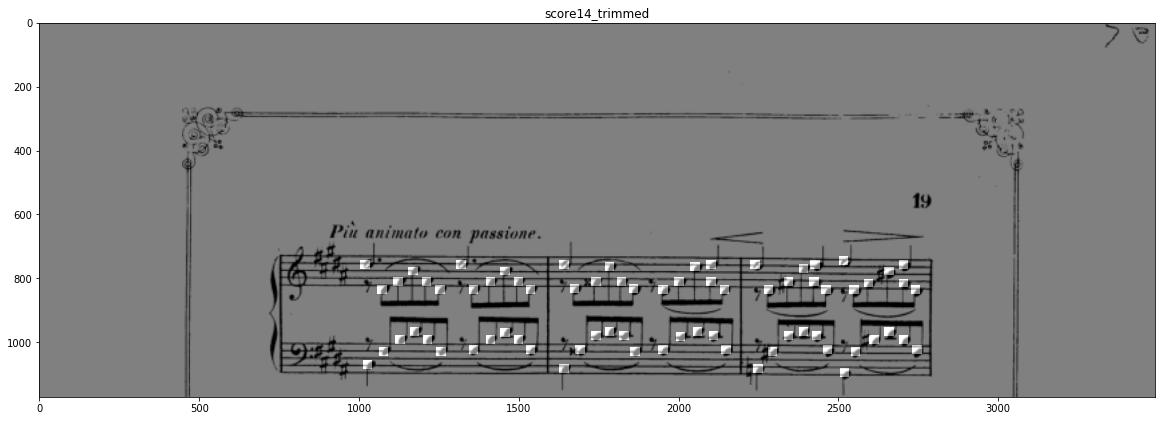

In [568]:
for key in ['score14_trimmed']:
    plt.figure(figsize=(20,20))
    plt.imshow(annotations[key][0][:,:], cmap='gray')
    plt.imshow(annotations[key][1][:,:], cmap='gray', alpha=0.5)
    boxes = annotations[key][2]
    plt.title(key)
    plt.show()

In [509]:
def plotRegion(img1, img2, r1, c1, r2, c2, pad=10, figsize=(10,10)):
    r1 -= pad
    r2 += pad
    c1 -= pad
    c2 += pad
    plt.figure(figsize=figsize)
#     plt.subplot(1,2,1)
    plt.imshow(img1[r1:r2, c1:c2], cmap='gray')
    plt.imshow(img2[r1:r2, c1:c2], cmap='gray', alpha=0.5)
#     plt.subplot(1,2,2)
    test_img = 255 - img1[r1:r2, c1:c2]
    test_img = ndimage.gaussian_filter(test_img, sigma=(5, 5), order=2)
    filter_img = np.ones((r2-r1-2*pad, c2-c1-2*pad))
    outs = signal.convolve2d(test_img, filter_img, 'same')
    plt.imshow(outs, alpha=0.6)
    plt.colorbar(heatmap)
    plt.show()

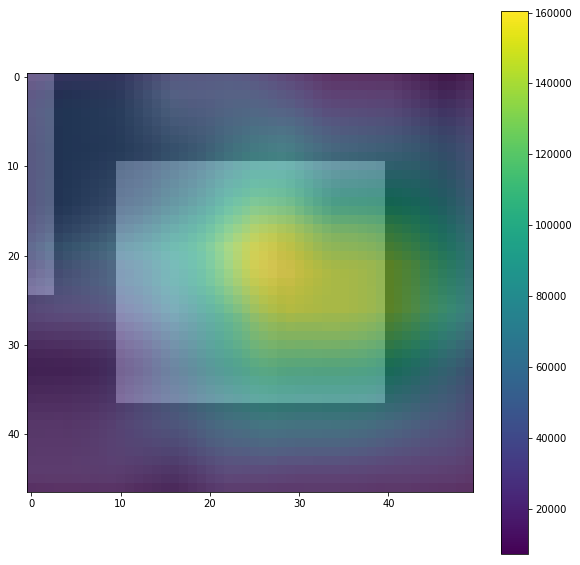

In [140]:
plotRegion(annotations[key][0], annotations[key][1], annotations[key][2][6][1], 
                                                     annotations[key][2][6][0],
                                                     annotations[key][2][6][3], 
                                                     annotations[key][2][6][2])

In [133]:
from scipy import signal
import scipy.ndimage as ndimage

In [222]:
pad = (7, 10)
calibrated_boxes = []
for box in boxes:
    r1 = box[1] - pad[0]
    r2 = box[3] + pad[0]
    c1 = box[0] - pad[1]
    c2 = box[2] + pad[1]
    img = 255 - annotations[key][0][r1:r2, c1:c2]
    img = ndimage.gaussian_filter(img, sigma=(3, 3), order=0)
    img = ndimage.gaussian_filter(img, sigma=(3, 3), order=0)
    filter_img = np.ones((r2-r1-2*pad[0], c2-c1-2*pad[1]))
    outs = signal.convolve2d(img, filter_img, 'same')
    outs = ndimage.gaussian_filter(outs, sigma=(3, 3), order=0)
    
    center = np.unravel_index(np.argmax(outs), outs.shape)
    shift = (center[0] - img.shape[0]/2, center[1] - img.shape[1]/2) # (r,c)
    calibrated_boxes.append((box[0] + shift[1], box[1] + shift[0], box[2] + shift[1], box[3] + shift[0]))  # (x1,y1,x2,y2)

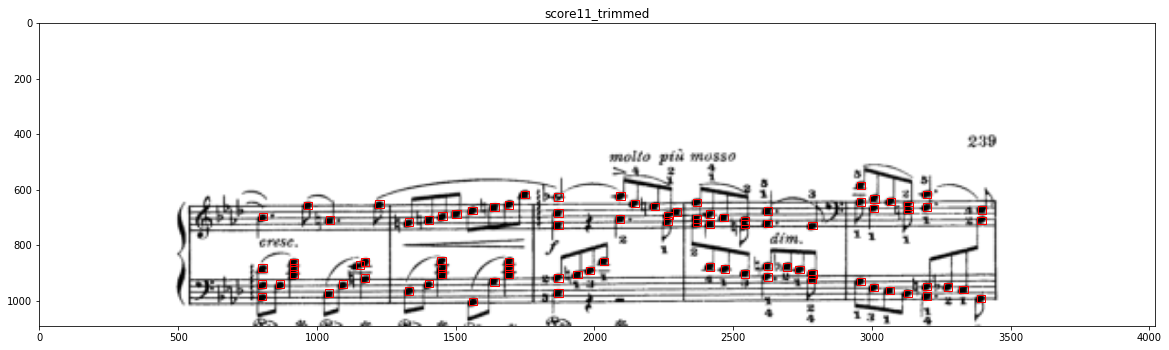

In [223]:
for key in ['score11_trimmed']:
    fig, ax = plt.subplots(1, figsize=(20,20))
    ax.imshow(annotations[key][0], cmap='gray')
    for box in calibrated_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, 
                                 edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title(key)
    plt.show()

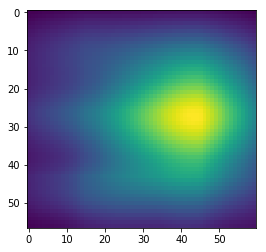

In [168]:
outs = signal.convolve2d(test_img, filter_img, 'same')
plt.imshow(outs)

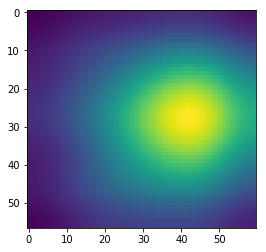

In [171]:
outs2 = ndimage.gaussian_filter(outs, sigma=(5, 5), order=0)
plt.imshow(outs2)

In [194]:
ii = np.mean(np.unravel_index(np.argsort(outs.ravel())[-2:], outs.shape), axis=0)

In [195]:
ii

array([29.5, 29. ])